# StrategicFL: Shakespeare Demo Experiment

Demonstrating strategic federated learning with a free-riding client

In [ ]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from shakespearedataset import ShakespeareDataset
from torch import nn
from torch.utils.data import DataLoader

from models import LSTM
from strategicfl.agents import Client, Server
from strategicfl.utils.actions import create_freeriding_action, create_scalar_action
from strategicfl.utils.aggregation import get_aggregate
from strategicfl.utils.evaluate import evaluate_with_ids
from strategicfl.utils.metrics import get_gradient_metrics

## Preparation/initialization

### Setup device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [3]:
config = {
    "training": {
        "T": 1000,
        "lr": 0.06,
        "local_steps": 1,
        "batch_size": 16,
        "eval_batch_size": 64,
    },
    "clients": {
        "n_players": 10,
        "alpha_0": 1.0,
        "alpha_1": 1.0,
        "beta_0": 0.0,
        "beta_1": 0.0,
    },
    "aggregation": {"method": "mean"},
    "data": {
        "train_path": "../../data/shakespeare/train.json",
        "test_path": "../../data/shakespeare/test.json",
        "truncate_size": 1000,
    },
    "model": {"seq_len": 80, "num_classes": 80, "n_hidden": 256, "embedding_dim": 8},
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 1000
    lr: 0.06
    local_steps: 1
    batch_size: 16
    eval_batch_size: 64
  clients:
    n_players: 10
    alpha_0: 1.0
    alpha_1: 1.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/shakespeare/train.json
    test_path: ../../data/shakespeare/test.json
    truncate_size: 1000
  model:
    seq_len: 80
    num_classes: 80
    n_hidden: 256
    embedding_dim: 8


### Loading the Shakespeare data

In [5]:
def get_data(path: str):
    with open(path, "r") as f:
        data = json.load(f)
        user_names = data["users"]
        data_dict = data["user_data"]
    return data_dict, user_names


print("\nLoading Shakespeare data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, _ = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Sample user data size: {len(data_dict[user_names[0]]['x'])} samples")

# DATA TRUNCATION
if config["data"]["truncate_size"] > 0:
    print(f"Truncating data to last {config['data']['truncate_size']} samples...")

    for key in data_dict.keys():
        try:
            if (
                isinstance(data_dict[key], dict)
                and "x" in data_dict[key]
                and "y" in data_dict[key]
            ):
                data_dict[key]["x"] = data_dict[key]["x"][
                    -config["data"]["truncate_size"] :
                ]
                data_dict[key]["y"] = data_dict[key]["y"][
                    -config["data"]["truncate_size"] :
                ]
        except Exception as e:
            print(f"Error processing key {key}: {e}")

    for key in test_data_dict.keys():
        try:
            if (
                isinstance(test_data_dict[key], dict)
                and "x" in test_data_dict[key]
                and "y" in test_data_dict[key]
            ):
                test_data_dict[key]["x"] = test_data_dict[key]["x"][
                    -config["data"]["truncate_size"] :
                ]
                test_data_dict[key]["y"] = test_data_dict[key]["y"][
                    -config["data"]["truncate_size"] :
                ]
        except Exception as e:
            print(f"Error processing test key {key}: {e}")


Loading Shakespeare data...
Training data: 799 users
Sample user data size: 400 samples
Truncating data to last 1000 samples...


### Creating a Server agent with LSTM model

In [6]:
print("\nCreating server...")
server_model = LSTM(
    seq_len=config["model"]["seq_len"],
    num_classes=config["model"]["num_classes"],
    n_hidden=config["model"]["n_hidden"],
    embedding_dim=config["model"]["embedding_dim"],
).to(device)

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(server_model.parameters(), lr=config["training"]["lr"]),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
    agent_id="server",
)

print(f"Created server with {config['aggregation']['method']} aggregation")



Creating server...
Created server with mean aggregation


### Creating a group of Client agents
All but one clients are honest, one client is free-riding.

In [ ]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "bad"
        print(
            f"  Client {i + 1}: BAD - {len(client_user_names)} users"
        )
        action = create_freeriding_action()
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"good{i}"
        print(
            f"  Client {i + 1}: GOOD - {len(client_user_names)} users"
        )
        action = create_scalar_action(alpha, beta)

    train_dataset = ShakespeareDataset(client_user_names, data_dict)
    test_dataset = ShakespeareDataset(client_user_names, test_data_dict)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    client_model = LSTM(
        seq_len=config["model"]["seq_len"],
        num_classes=config["model"]["num_classes"],
        n_hidden=config["model"]["n_hidden"],
        embedding_dim=config["model"]["embedding_dim"],
    ).to(device)

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(
            client_model.parameters(), lr=config["training"]["lr"]
        ),
        action=create_scalar_action(alpha, beta),
        agent_id=agent_id,
    )

    clients.append(client)



Creating clients...
  Client 1: honest (α=1.0, β=0.0) - 79 users
  Client 2: honest (α=1.0, β=0.0) - 79 users
  Client 3: honest (α=1.0, β=0.0) - 79 users
  Client 4: honest (α=1.0, β=0.0) - 79 users
  Client 5: honest (α=1.0, β=0.0) - 79 users
  Client 6: honest (α=1.0, β=0.0) - 79 users
  Client 7: honest (α=1.0, β=0.0) - 79 users
  Client 8: honest (α=1.0, β=0.0) - 79 users
  Client 9: honest (α=1.0, β=0.0) - 79 users
  Client 10: ADVERSARIAL (α=1.0, β=0.0) - 79 users


## Run federated training

In [9]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

all_losses, all_metrics = server.train(
    clients=clients,
    T=config["training"]["T"],
    get_metrics=get_gradient_metrics,
)

print("Training completed!")


Starting federated training for 1000 rounds...


Federated Training: 100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]

Training completed!


## Evaluate final performance

In [10]:
print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
good0: Accuracy = 0.1888, Loss = 3.1428
good1: Accuracy = 0.1887, Loss = 3.1318
good2: Accuracy = 0.1864, Loss = 3.1494
good3: Accuracy = 0.1895, Loss = 3.1402
good4: Accuracy = 0.1872, Loss = 3.1460
good5: Accuracy = 0.1900, Loss = 3.1430
good6: Accuracy = 0.1874, Loss = 3.1264
good7: Accuracy = 0.1885, Loss = 3.1387
good8: Accuracy = 0.1897, Loss = 3.1517
bad: Accuracy = 0.1880, Loss = 3.1563


## Visualize training process

Figure saved as 'shakespeare_training_metrics.png'


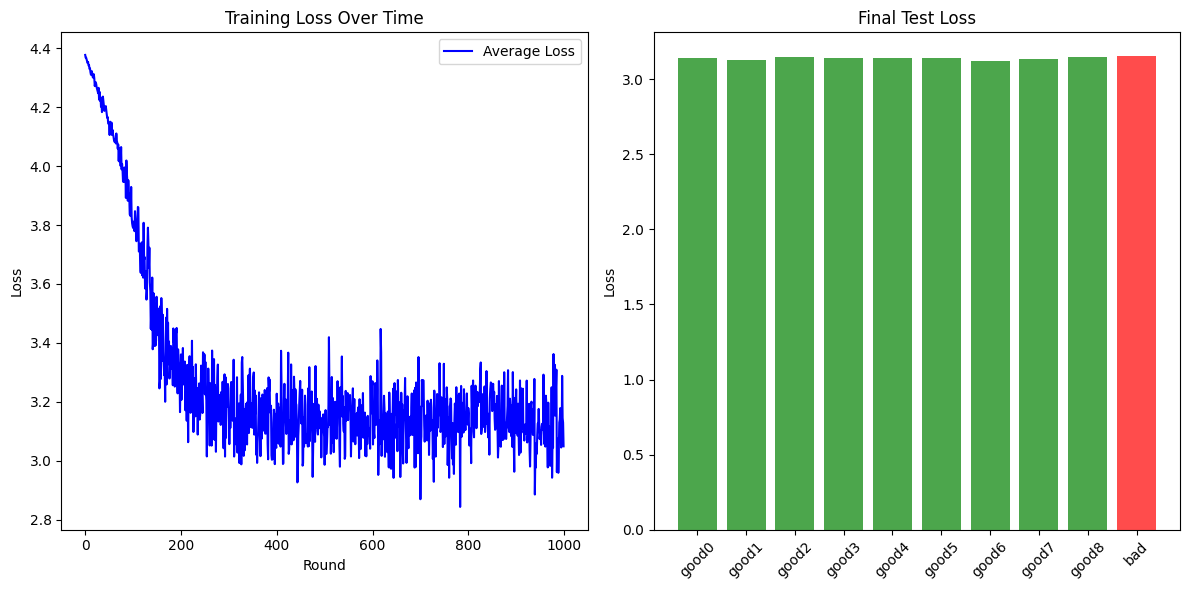

In [12]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training losses over time
axes[0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")
# axes[0].fill_between(
#     range(len(losses_array)),
#     losses_array.min(axis=1),
#     losses_array.max(axis=1),
#     alpha=0.3,
#     color="blue",
# )
axes[0].set_title("Training Loss Over Time")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend()

# # Individual client losses
# for i in range(config["clients"]["n_players"]):
#     client_type = (
#         "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
#     )
#     axes[0, 1].plot(losses_array[:, i], label=client_type, alpha=0.7)
# axes[0, 1].set_title("Individual Client Losses")
# axes[0, 1].set_xlabel("Round")
# axes[0, 1].set_ylabel("Loss")
# axes[0, 1].legend()

# # Gradient norms
# for i in range(config["clients"]["n_players"]):
#     client_type = (
#         "Adversarial" if i == config["clients"]["n_players"] - 1 else f"Honest {i + 1}"
#     )
#     axes[1, 0].plot(grad_norms_array[:, i], label=client_type, alpha=0.7)
# axes[1, 0].set_title("Gradient Norms Over Time")
# axes[1, 0].set_xlabel("Round")
# axes[1, 0].set_ylabel("Gradient Norm")
# axes[1, 0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1].set_title("Final Test Loss")
axes[1].set_ylabel("Loss")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

# Save the figure to file
fig_filename = 'shakespeare_training_metrics'
plt.savefig(f'{fig_filename}.png', dpi=300, bbox_inches='tight')
print(f"Figure saved as '{fig_filename}.png'")

plt.show()

### Experiment summary

In [26]:
print("\n" + "=" * 50)
print("EXPERIMENT SUMMARY")
print("=" * 50)
print("\nConfiguration:")
print(
    f"  Honest clients (a={config['clients']['alpha_0']}, b={config['clients']['beta_0']})"
)
print(
    f"  Adversarial client (a={config['clients']['alpha_1']}, b={config['clients']['beta_1']})"
)
print(f"  Training rounds: {config['training']['T']}")

print(f"\nFinal Results with {config['aggregation']['method']} aggregation:")
for client_id, acc in final_accuracy.items():
    loss = final_loss[client_id]
    acc_val = float(acc) if hasattr(acc, "item") else acc
    loss_val = float(loss) if hasattr(loss, "item") else loss
    print(f"  {client_id}: {acc_val:.4f} accuracy, {loss_val:.4f} loss")

# For the final comparison, get the adversarial client's performance
adversarial_acc = final_accuracy.get("bad", final_accuracy.get("adversarial"))
honest_accs = [
    final_accuracy[k]
    for k in final_accuracy.keys()
    if k != "bad" and k != "adversarial"
]

if adversarial_acc is not None and honest_accs:
    adversarial_val = (
        float(adversarial_acc) if hasattr(adversarial_acc, "item") else adversarial_acc
    )
    honest_vals = [float(acc) if hasattr(acc, "item") else acc for acc in honest_accs]


EXPERIMENT SUMMARY

Configuration:
  Honest clients (α=1.0, β=0.0)
  Adversarial client (α=1.0, β=0.0)
  Training rounds: 50

Final Results with mean aggregation:
  good0: 0.1885 accuracy, 4.3092 loss
  good1: 0.1883 accuracy, 4.3094 loss
  bad: 0.1887 accuracy, 4.3094 loss


### [Optional] Saving the results

In [27]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicfl_demo_shakespeare.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicfl_demo_shakespeare.pkl")

Results saved to strategicfl_demo_shakespeare.pkl
